In [ ]:
# Libraries
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.models import Model, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, LeakyReLU, ReLU, Activation
from keras.optimizers import adam_v2
from keras.initializers import RandomNormal
from keras.utils.vis_utils import plot_model

# Connecting drive for dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def dis_layer(filter, in_layer, strides=(2,2), apply_batchnorm=True):
  init = RandomNormal(stddev=0.02)
  node = Conv2D(filter, (4,4), strides=strides, padding='same', kernel_initializer=init)(in_layer)
  if apply_batchnorm:
    node = BatchNormalization()(node)
  node = LeakyReLU(alpha=0.2)(node)
  return node

In [ ]:
def discriminator(image_shape):
  init = RandomNormal(stddev=0.02)
  input_src_image = Input(shape=image_shape)
  input_target_image = Input(shape=image_shape)

  # concatenate images, channel-wise
  merge = Concatenate()([input_src_image, input_target_image])

  d1 = dis_layer(64, merge, apply_batchnorm=False)
  d2 = dis_layer(128, d1)
  d3 = dis_layer(256, d2)
  d4 = dis_layer(512, d3)
  d5 = dis_layer(512, d4, strides=(1,1))
  out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d5)
  out = Activation('sigmoid')(out)

  # model
  model = Model([input_src_image, input_target_image], out)
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5), loss_weights=[0.5])
  return model

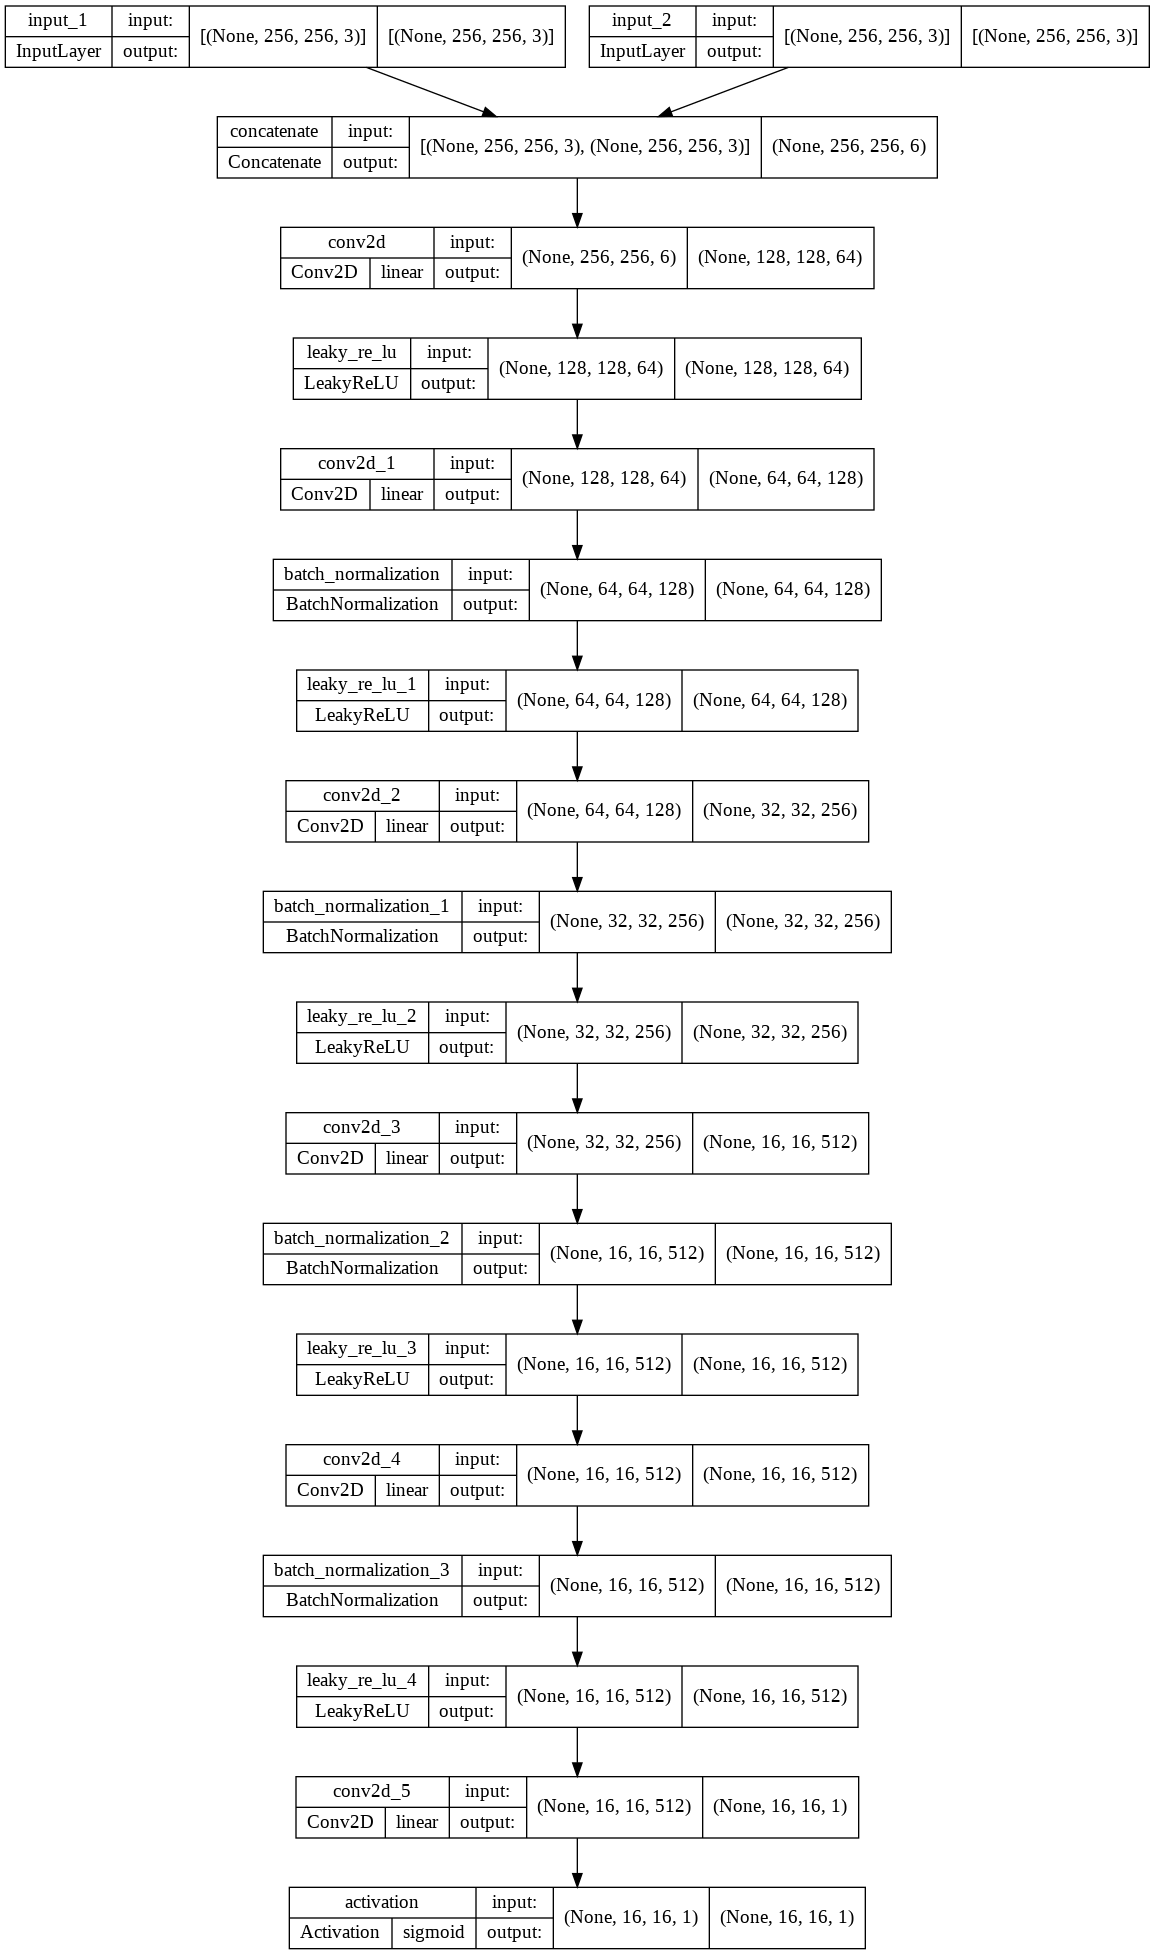

In [ ]:
d = discriminator((256, 256, 3))
tf.keras.utils.plot_model(d, show_shapes=True, dpi=96, show_layer_activations=True)

In [ ]:
def encoder(layer_in, filters, apply_batchnorm=True):
  init = RandomNormal(stddev=0.02)
  node = Conv2D(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
  if apply_batchnorm:
    node = BatchNormalization()(node, training=True)
  node = LeakyReLU(alpha=0.2)(node)
  return node

In [ ]:
def decoder(layer_in, skip_in, filters, dropout=True):
  init = RandomNormal(stddev=0.02)
  node = Conv2DTranspose(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
  node = BatchNormalization()(node, training=True)
  if dropout:
    node = Dropout(0.5)(node, training=True)
  node = Concatenate()([node, skip_in])
  node = Activation('relu')(node)
  return node

In [ ]:
def generator(image=(256, 256, 3)):
  init = RandomNormal(stddev=0.02)
  in_image = Input(shape=image)
  # encoder part
  e1 = encoder(in_image, 64, apply_batchnorm=False)
  e2 = encoder(e1, 128)
  e3 = encoder(e2, 256)
  e4 = encoder(e3, 512)
  e5 = encoder(e4, 512)
  e6 = encoder(e5, 512)
  e7 = encoder(e6, 512)
  # bottleneck
  b = Conv2D(512, (4,4), strides=(2,2),padding='same', kernel_initializer=init)(e7)
  b = Activation('relu')(b)
  # decoder
  d1 = decoder(b, e7, 512)
  d2 = decoder(d1, e6, 512)
  d3 = decoder(d2, e5, 512)
  d4 = decoder(d3, e4, 512, dropout=False)
  d5 = decoder(d4, e3, 256, dropout=False)
  d6 = decoder(d5, e2, 128, dropout=False)
  d7 = decoder(d6, e1, 64, dropout=False)
  # output
  output = Conv2DTranspose(image[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
  output_image = Activation('tanh')(output)
  # model
  model = Model(in_image, output_image)
  return model

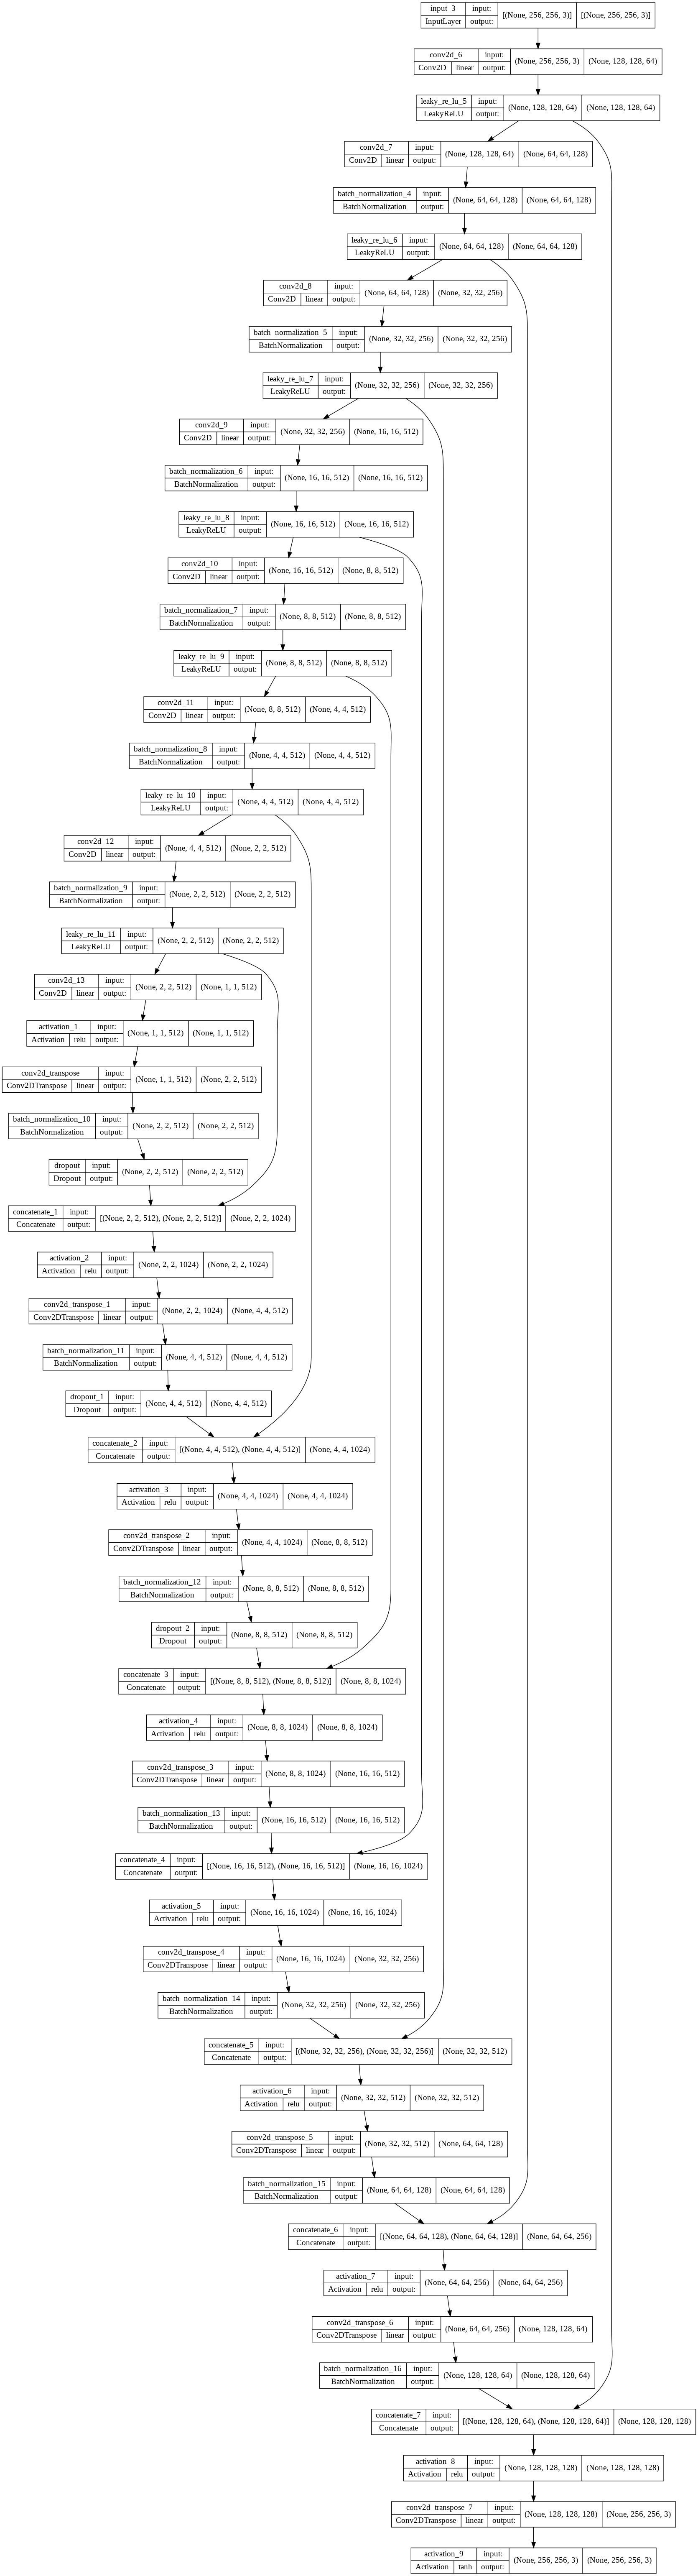

In [ ]:
g = generator()
tf.keras.utils.plot_model(g, show_shapes=True, dpi=96, show_layer_activations=True)

In [ ]:
def gan_model(generator_model, discriminator_model, image_shape):
  # make weights in the discriminator not trainable
  for layer in discriminator_model.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False
  
  # 
  src = Input(shape=image_shape)
  generated_output = generator_model(src)
  discriminator_output = discriminator_model([src, generated_output])
  model = Model(src, [discriminator_output, generated_output])
  opt = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])
  return model

In [ ]:
def generate_real_samples(dataset, samples, patchshape):
  trainA, trainB = dataset
  ix = np.random.randint(0, trainA.shape[0], samples)
  X1, X2 = trainA[ix], trainB[ix]
  y = np.ones((samples, patchshape, patchshape, 1))
  return [X1, X2], y

In [ ]:
def generate_fake_samples(generator_model, samples, patchshape):
  X = generator_model.predict(samples)
  y = np.zeros((len(X), patchshape, patchshape, 1))
  return X, y

In [ ]:
def train(discriminator_model, generator_model, gan_model, dataset, epochs=100, batch=1):
  n_patch = discriminator_model.output_shape[1]
  trainA, trainB = dataset
  batch_per_epoch = len(trainA) // batch
  steps = batch_per_epoch * epochs
  for i in range(steps):
    [XrealA, XrealB], yreal = generate_real_samples(dataset, batch, n_patch)
    XfakeB, yfake = generate_fake_samples(generator_model, XrealA, n_patch)
    dloss1 = discriminator_model.train_on_batch([XrealA, XrealB], yreal)
    dloss2 = discriminator_model.train_on_batch([XrealA, XfakeB], yfake)
    gloss, bce, mae = gan_model.train_on_batch(XrealA, [yreal, XrealB])
    print('>%d, d1[%.3f] d2[%.3f] g[%.3f] bce[%.3f] mae[%.3f]' % (i+1, dloss1, dloss2, gloss, bce, mae))
    #if (i+1) % (batch_per_epoch * 10) == 0:
      #summary(i, gan_model, dataset)
  generator_model.save('Model Saved.h5')
  print('Model saved!!')

In [ ]:
def summary(step, g_model, dataset, n_samples=3):
  [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
  X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
  X_fakeB = np.asarray(X_fakeB)
	# scale all pixels from [-1,1] to [0,1]
  X_realA = (X_realA + 1) / 2.0
  X_realB = (X_realB + 1) / 2.0
  X_fakeB = (X_fakeB + 1) / 2.0
  # plot real source images
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(X_realA[i])
  # plot generated target image
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(X_fakeB[i])
  # plot real target image
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples*2 + i)
    plt.axis('off')
    plt.imshow(X_realB[i])
  # save plot to file
  filename1 = 'plot_%06d.png' % (step+1)
  plt.savefig(filename1)
  plt.close()

In [ ]:
# Some other libraries for running the file


In [ ]:
# Function to split the data in two equal parts for better processing
def split_image(image_file):
  w = tf.shape(image)[1]
  w = w // 2
  satellite = image[:, :w, :]
  map = image[:, w:, :]
  satellite = tf.image.resize(satellite, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  map = tf.image.resize(map, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return satellite, map

In [ ]:
def preprocess_image_data(satellite, map):
  satellite = (np.asarray(satellite) - 127.5) / 127.5
  map = (np.asarray(map) - 125.5) / 127.5
  return [satellite, map]

In [ ]:
# Dataset Files in drive
file_root = '/content/drive/MyDrive/Colab Notebooks/Honours/Satellite image to vector map/dataset/'
train_path = file_root + 'train/'
test_path = file_root + 'test/'

# Train image dataset
train_image_satellite = []
train_image_map = []
train_image_name = []
train_images_list = os.listdir(train_path)
for i, name in enumerate(train_images_list):
  if name.endswith(".jpg"):
    image = cv2.imread(train_path + name)[:,:,::-1]
    satellite, map = split_image(image)
    train_image_satellite.append(satellite)
    train_image_map.append(map)
    train_image_name.append(name)



In [ ]:
# Test image dataset
test_image_satellite = []
test_image_map = []
test_image_name = []
test_images_list = os.listdir(test_path)
for i, name in enumerate(test_images_list):
  if name.endswith(".jpg"):
    image = cv2.imread(test_path + name)[:,:,::-1]
    satellite, map = split_image(image)
    test_image_satellite.append(satellite)
    test_image_map.append(map)
    test_image_name.append(name)

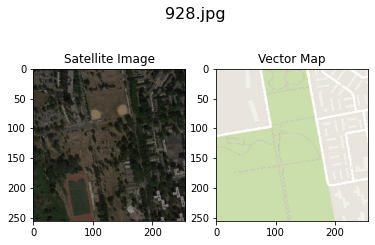

In [ ]:
# Showing random image from the training dataset
num = random.randint(0, len(train_image_satellite)) # Both array have same size

plt.figure()
plt.subplot(121)
plt.imshow(train_image_satellite[num])
plt.title('Satellite Image')
plt.subplot(122)
plt.imshow(train_image_map[num])
plt.title('Vector Map')
plt.suptitle(train_image_name[num], fontsize=16)
plt.show()

Now we will define some code blocks which we will be using in our model.

In [ ]:
image_shape = train_image_satellite[1].shape
discriminator_model = discriminator(image_shape)
generator_model = generator(image_shape)
gan = gan_model(generator_model, discriminator_model, image_shape)
dataset = preprocess_image_data(train_image_satellite, train_image_map)
train(discriminator_model, generator_model, gan, dataset, epochs=20, batch=10)

>1, d1[0.309] d2[3.500] g[75.250] bce[2.438] mae[0.728]
>2, d1[1.810] d2[1.972] g[55.693] bce[0.983] mae[0.547]
>3, d1[0.493] d2[0.771] g[36.870] bce[1.725] mae[0.351]
>4, d1[0.905] d2[0.565] g[20.394] bce[1.406] mae[0.190]
>5, d1[0.731] d2[0.786] g[17.133] bce[1.053] mae[0.161]
>6, d1[0.520] d2[0.619] g[16.766] bce[1.295] mae[0.155]
>7, d1[0.623] d2[0.521] g[14.029] bce[1.219] mae[0.128]
>8, d1[0.630] d2[0.689] g[16.885] bce[1.093] mae[0.158]
>9, d1[0.545] d2[0.677] g[21.684] bce[1.053] mae[0.206]
>10, d1[0.535] d2[0.598] g[15.430] bce[1.239] mae[0.142]
>11, d1[0.544] d2[0.446] g[14.356] bce[1.150] mae[0.132]
>12, d1[0.629] d2[0.729] g[19.528] bce[1.116] mae[0.184]
>13, d1[0.465] d2[0.385] g[12.388] bce[1.262] mae[0.111]
>14, d1[0.657] d2[0.545] g[14.003] bce[1.011] mae[0.130]
>15, d1[0.455] d2[0.490] g[12.170] bce[1.175] mae[0.110]
>16, d1[0.525] d2[0.409] g[12.391] bce[1.203] mae[0.112]
>17, d1[0.494] d2[0.377] g[11.434] bce[1.260] mae[0.102]
>18, d1[0.677] d2[0.600] g[13.819] bce[0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


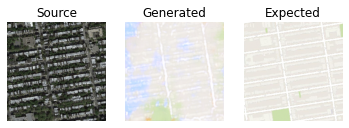

921.jpg


In [ ]:
from keras.models import load_model
model = load_model('Model Saved.h5')

def plot(src_img, generated_image, target_image):
  images = np.vstack((src_img, generated_image, target_image))
  images = (images + 1) / 2.0
  titles = ['Source', 'Generated', 'Expected']
  for i in range(len(images)):
    plt.subplot(1, 3, 1+i)
    plt.axis('off')
    plt.imshow(images[i])
    plt.title(titles[i])
  plt.show()

dataset = preprocess_image_data(test_image_satellite, test_image_map)
[X1, X2] = dataset
i = np.random.randint(0, len(X1), 1)
src_img, target_image = X1[i], X2[i]
generated_image = model.predict(src_img)
plot(src_img, generated_image, target_image)
print(np.asarray(test_image_name[i[0]]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


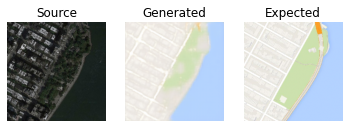

777.jpg


In [ ]:
dataset = preprocess_image_data(train_image_satellite, train_image_map)
[X1, X2] = dataset
i = np.random.randint(0, len(X1), 1)
src_img, target_image = X1[i], X2[i]
generated_image = model.predict(src_img)
plot(src_img, generated_image, target_image)
print(np.asarray(train_image_name[i[0]]))